## Experiments in improving segmentation performance for lung ultrasound (LSU):

An overview:

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In this nb, I try and use the training approach used in the [cat segmentation nb](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb).

In [1]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.5.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 99.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b5b944a17a3530f7dccff616add330042c680e2242cd92e0a9b88d49a6f73961
  Stored in directory: /root/.cache/pip/wheels/22/16/f1/5369d23a06852d5f083d23a1addf0904575f1296f71b412ac8
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=e8820e5e6f7c5144ae3815fb80a1d1be58e29f355f53c8d95c9ce7b27395f969
  Stored in directory: /root/.cache/pip/wheels/1f/9b/f5/9ccf39b50bc437986145107e2ced70a6fab622cf23e4795aa5
Successfully built efficientnet-pyto

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

In [3]:
import pytorch_lightning as pl
print(pl.__version__)

1.5.4


In [41]:
# !pip install -U pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 39.9 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.5.4
    Uninstalling pytorch-lightning-1.5.4:
      Successfully uninstalled pytorch-lightning-1.5.4


## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [5]:
from PIL import Image
import os

In [6]:
with Image.open('/notebooks/pleural_line_segment/init_play/baby_dataset/origin/imgs/158-1_frame_0.jpg') as img:
        width, height= img.size
        
print(width, height)

960 720


Having a bunch of errors in trying to reshape the data to (3, 960, 720). First let's see what the data shape really is.

In [7]:
from PIL import Image
import torch
from torchvision import transforms

# Load the image
image = Image.open('/notebooks/pleural_line_segment/init_play/baby_dataset/origin/imgs/158-1_frame_0.jpg').convert('RGB')

# Define a transform to convert the image to tensor
transform = transforms.ToTensor()

# Apply the transform to the image
image_tensor = transform(image)

print(image_tensor.shape)  # Check the shape of the tensor

torch.Size([3, 720, 960])


Divisible by 32? 960 is, 720 is not - will have to add padding.

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        # Handle the image shape (3, 720, 960)
        if image.shape[0] == 3:
            image = image.transpose(1, 2, 0)  # Convert to (720, 960, 3)

        # Handle the mask shape (1, 720, 960)
        elif image.shape[0] == 1:
            image = np.squeeze(image, axis=0)  # Squeeze to (720, 960)

        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [11]:
import numpy as np

def pad_im(image):
    # Pad the image
    total_pad = 736 - 720
    pad_top = total_pad // 2
    pad_bottom = total_pad - pad_top
    padded_im = np.pad(image, ((0, 0), (pad_top, pad_bottom), (0, 0)), mode='constant')
    
    return padded_im

# def pad_mask(mask):
#     # Pad the image
#     total_pad = 736 - 720
#     pad_top = total_pad // 2
#     pad_bottom = total_pad - pad_top
#     padded_mask = np.pad(mask, ((0, 0), (pad_top, pad_bottom), (0, 0)), mode='constant')
    
#     return padded_mask

def convert_mask(mask):
    # Reshape mask from (720, 960, 3) to (3, 720, 960)
    # mask_reshaped = np.transpose(mask, (2, 0, 1))
    # Convert RGB to Grayscale
    # The weights (0.2989, 0.5870, 0.1140) are common for converting RGB to Grayscale
    # gray_mask = 0.2989 * mask[0] + 0.5870 * mask[1] + 0.1140 * mask[2]
    # summed_image = np.sum(mask, axis=0, keepdims=True)
    # summed_image = mask
    # threshold = 200
    # Apply threshold: values greater than the threshold become 1, others become 0
    # binary_image = np.where(summed_image > threshold, 1, 0)

    # msk_array = np.asarray(msk)
    norm_mask = mask / 255.0

    # Add an extra dimension to make it (1, 720, 960)
    # gray_mask = np.expand_dims(gray_mask, axis=0)
    mask_expanded = np.expand_dims(norm_mask, axis=0)
    
    return mask_expanded

# Example usage
# Assuming `original_mask` is your input mask with shape (720, 960, 3)

# converted_mask = convert_mask(original_mask)
# print("Converted mask shape:", converted_mask.shape)

### Quick Test of Operations

In [12]:
img = Image.open('/notebooks/pleural_line_segment/init_play/baby_dataset/origin/imgs/158-1_frame_0.jpg')
msk = Image.open('/notebooks/pleural_line_segment/init_play/baby_dataset/train/mask/163-2_frame_59.png')

msk_array = np.asarray(msk)

Actually just have to test the mask. The values have to be normalized to be within values 0 to 1.

In [14]:
print("Original pixel values:")
print(msk_array)

Original pixel values:
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


In [15]:
normalized_msk_array = msk_array / 255.0
print("Normalized pixel values:")
print(normalized_msk_array)

Normalized pixel values:
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


In [16]:
normalized_msk_array

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [33]:
print(msk)

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=960x720 at 0x7FABB02B8D30>


## Dataloader

In [13]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
#     CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
#                'tree', 'signsymbol', 'fence', 'car', 
#                'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg', '.png')) for image_id in self.ids]
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1))
        image = pad_im(image)
        
        # image = convert_im(image)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = convert_mask(mask)
        mask = pad_im(mask)
        
        # print("Image data type:", type(image))
        # print("Image shape:", image.shape)
        # print("Mask shape:", mask.shape)
        
        # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in self.class_values]
        # mask = np.stack(masks, axis=-1).astype('float')
        
            
        return {"image": image, "mask": mask}
        # return image, mask
        
    def __len__(self):
        return len(self.ids)

Let's try and see the data we have:

In [14]:
x_valid_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/val/image'
y_valid_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/val/mask'

x_test_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/val/image'
y_test_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/val/mask'

In [15]:
x_train_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/train/image'
y_train_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/train/mask'
dataset = Dataset(x_train_dir, y_train_dir)
# print(dataset)

In [16]:
dataset[1]["image"]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

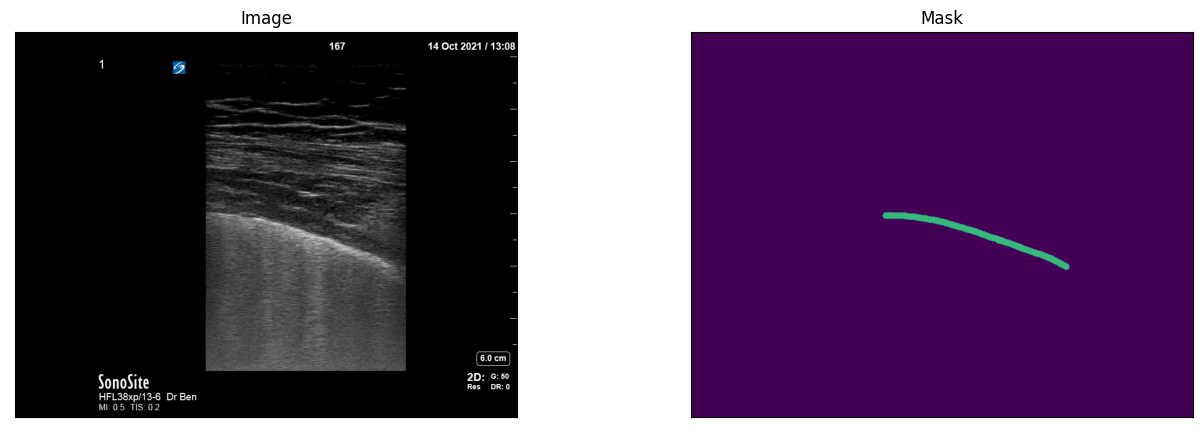

In [17]:
image, mask = dataset[1] # get some sample
visualize(
    image=dataset[1]["image"], 
    mask=dataset[1]["mask"],
)

In [18]:
mask=dataset[1]["mask"]
max(mask), mask.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (1, 736, 960))

Okay, thankfully the data frickin works! But I think the mask is inverted - which shouldn't be a tough fix. Now let's give this a shot. Can also add data augmentations based on this [nb](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb).

In [19]:
import torch
from torch import tensor
import pandas as pd

In [20]:
msk=dataset[1]["mask"]
msk_t = tensor(msk)
# df = pd.DataFrame(mask[4:15,4:22])
df = pd.DataFrame(mask.squeeze()[340:390, 400:600])
print(df.shape)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

(50, 200)


See, the mask is currently with a value of only around 0.2 to 0.5 ish!! So be careful, proceed with that knowledge.

In [25]:
def convert_mask(mask):
  
    # mask_inv = 255 - mask
    norm_mask = mask / 255.0

    # Add an extra dimension to make it (1, 720, 960)
    # gray_mask = np.expand_dims(gray_mask, axis=0)
    mask_expanded = np.expand_dims(norm_mask, axis=0)
    
    return mask_expanded

# Example usage
# Assuming `original_mask` is your input mask with shape (720, 960, 3)

# converted_mask = convert_mask(original_mask)
# print("Converted mask shape:", converted_mask.shape)

In [21]:
#updated Dataset with mask processing
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        # self.ids = os.listdir(images_dir)
        self.ids = [file for file in os.listdir(images_dir) if file.endswith(('.jpg', '.png', '.jpeg')) and not file.startswith('.')]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg', '.png')) for image_id in self.ids]
        # self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        if image is None:
            raise FileNotFoundError(f"Unable to load image at {self.images_fps[i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1))
        image = pad_im(image)
        
        # image = convert_im(image)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = convert_mask(mask)
        mask = pad_im(mask)
            
        return {"image": image, "mask": mask}

    def __len__(self):
        return len(self.ids)

In [109]:
# from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [110]:
# download data
# root = "."
# SimpleOxfordPetDataset.download(root)

In [111]:
# init train, val, test sets
# train_dataset = SimpleOxfordPetDataset(root, "train")
# valid_dataset = SimpleOxfordPetDataset(root, "valid")
# test_dataset = SimpleOxfordPetDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
# assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
# assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
# assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

# print(f"Train size: {len(train_dataset)}")
# print(f"Valid size: {len(valid_dataset)}")
# print(f"Test size: {len(test_dataset)}")

# # n_cpu = os.cpu_count()
# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=n_cpu)
# valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)

In [27]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir
    # augmentation=get_training_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [28]:
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 8
Valid size: 1
Test size: 1


In [ ]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [30]:
import torch

# Check if CUDA (GPU support) is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Then use the device for your tensors and models
# Example:
# model.to(device)
# x, y = x.to(device), y.to(device)

## Model

In [23]:
class Model(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
    
# model = Model("FPN", "resnet34", in_channels=3, out_classes=1)

In [24]:
model = Model("FPN", "resnet34", in_channels=3, out_classes=1)

In [42]:
# for x, y in train_loader:
#     # Convert inputs to float and optionally normalize
#     x = x.float() / 255.0  # Normalize to 0-1 if your data is in 0-255 range

#     x, y = x.to(device), y.to(device)
    
# for x, y in valid_loader:
#     # Convert inputs to float and optionally normalize
#     x = x.float() / 255.0  # Normalize to 0-1 if your data is in 0-255 range

#     x, y = x.to(device), y.to(device)
    
# for x, y in test_loader:
#     # Convert inputs to float and optionally normalize
#     x = x.float() / 255.0  # Normalize to 0-1 if your data is in 0-255 range

#     x, y = x.to(device), y.to(device)

In [25]:
# model = Model("FPN", "resnet34", in_channels=3, out_classes=1)

## Training

In [31]:
print(model)

Model(
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2

In [32]:
print(train_loader)

In [33]:
print(valid_loader)

In [33]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=3,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [54]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=6,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Validation and test metrics

In [34]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.0, 'valid_per_image_iou': 0.0}]


In [35]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.0, 'test_per_image_iou': 0.0}]


# Result visualization

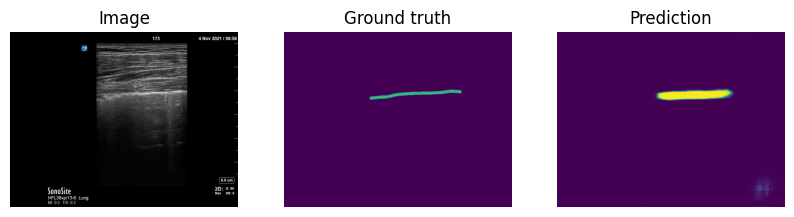

In [36]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

Alright, idk how that worked, but the model literally learned from 8 frames, and is able to infer a pretty good mask (which I think is even better than my 'ground truth'!). So - now going to run inference on all the 180 frames from the 173_1 video, and see how it does.  
(How? Create a new folder with the 180 frames of said video, create a `test_loader` and run inference. Then concatenate the results somehow and create a video)

(Note - version 15's checkpoint is just PERFECT in my opinion. Now, this version 24 checkpoint seems good too - it's a wee bit more enthusiastic and paints the mask with a 'broader' stroke - might be useful as a model that creates masks as an 'attention mask' input to some other model that is then about to run more specific inference).

### Clear Model

In [50]:
del model

In [46]:
del model_v15

NameError: name 'model_v15' is not defined

In [51]:
import torch
torch.cuda.empty_cache()

In [52]:
import gc
gc.collect()

2396

### Model Loading from Checkpoint

Alright, enough of this - let's figure this out and can then use ckpoint 15 as the good one, and 16 as the bad one.

In [53]:
class Model(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


In [48]:
model = Model("FPN", "resnet34", in_channels=3, out_classes=1)

yep, FPN is what worked. But also have to test using UNet!

In [54]:
#load the model that unexpectedly worked (on 8 images)
checkpoint_path_v15 = "/notebooks/pleural_line_segment/init_play/repos/segmentation_models.pytorch/lightning_logs/version_15/checkpoints/epoch=5-step=47.ckpt"

In [55]:
model_v15_new = Model.load_from_checkpoint(checkpoint_path=checkpoint_path_v15,
                                   arch="FPN",
                                   encoder_name="resnet34",
                                   in_channels=3,
                                   out_classes=1)

Loading from checkpoint complete!!

### Inference

In [112]:
#updated Dataset with mask processing
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        def extract_frame_number(filename):
            # Extract the frame number using a regular expression
            match = re.search(r'frame_(\d+)', filename)
            return int(match.group(1)) if match else 0
        # self.ids = os.listdir(images_dir)
        self.ids = [file for file in os.listdir(images_dir) if file.endswith(('.jpg', '.png', '.jpeg')) and not file.startswith('.')]
        # Sort the file list based on the frame number
        self.ids.sort(key=extract_frame_number)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg', '.png')) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        if image is None:
            raise FileNotFoundError(f"Unable to load image at {self.images_fps[i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1))
        image = pad_im(image)
        
        # image = convert_im(image)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = convert_mask(mask)
        mask = pad_im(mask)
            
        return {"image": image, "mask": mask}

    def __len__(self):
        return len(self.ids)

In [113]:
x_inf_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/inf/image'
y_inf_dir = '/notebooks/pleural_line_segment/init_play/baby_dataset/inf/mask'

In [114]:
# inf_dataset = InfDataset(
inf_dataset = Dataset(
    x_inf_dir, 
    y_inf_dir
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

In [115]:
inference_loader = DataLoader(inf_dataset, batch_size=1, shuffle=False, num_workers=4)

Let's try running inference:

In [116]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=3,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [117]:
# run test dataset
inf_metrics = trainer.test(model_v15_new, dataloaders=inference_loader, verbose=False)
pprint(inf_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 1.1526652997417841e-05,
  'test_per_image_iou': 1.1857335266540758e-05}]


Okay so, I can use my own simplifed code to run inference (and load checkpoint). But for now lemme try with the code that's here (no mask? just add the og images in mask folder).

In [ ]:
# # batch = next(iter(inference_loader))
# with torch.no_grad():
#     model.eval()
#     logits = model(batch["image"])
# pr_masks = logits.sigmoid()

# for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
#     plt.title("Image")
#     plt.axis("off")

#     plt.subplot(1, 3, 2)
#     plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
#     plt.title("Ground truth")
#     plt.axis("off")

#     plt.subplot(1, 3, 3)
#     plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
#     plt.title("Prediction")
#     plt.axis("off")

# model.eval()
#         logits = model(batch["image"])
#     plt.show()

Run inference on the 180 frames of video `173-1.avi`:  
(Note - Here, be careful to use the correct model instance! For example, use `model_v15_new` at every appropriate point, not `model`.)

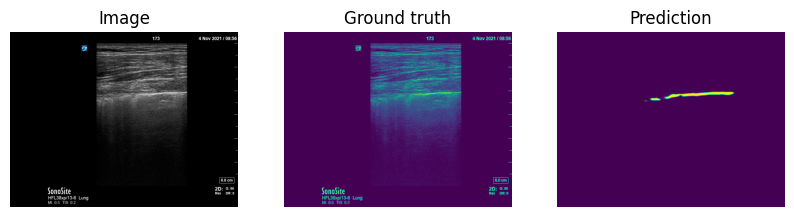

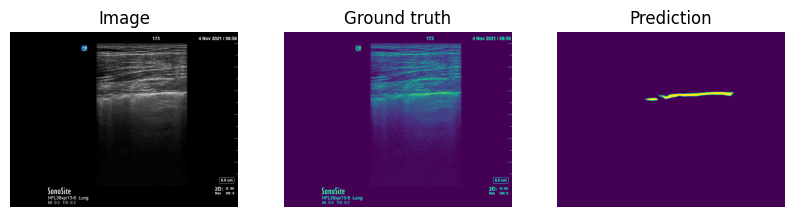

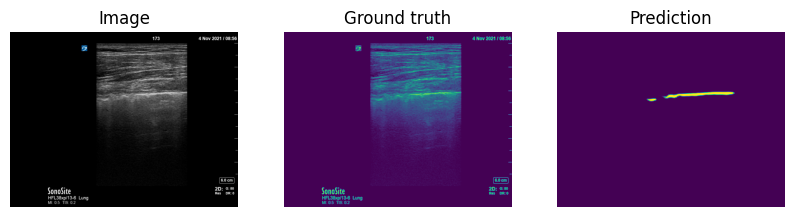

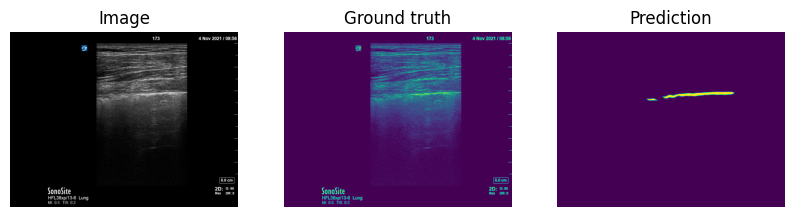

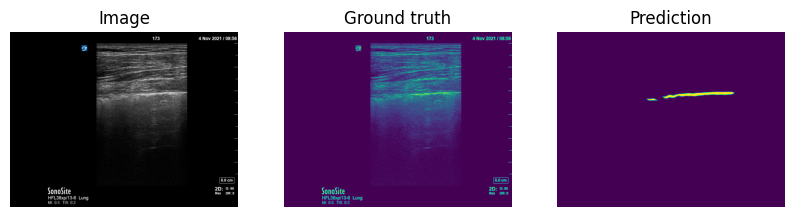

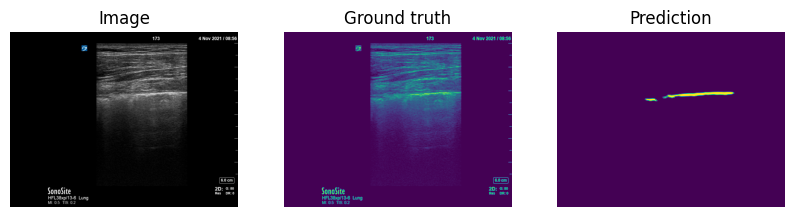

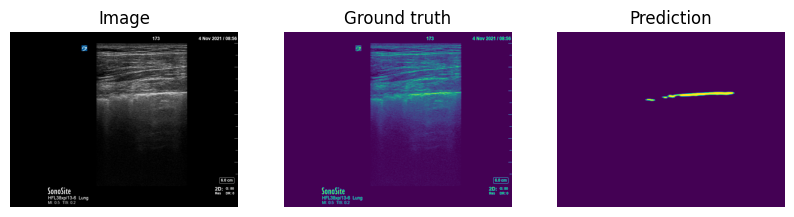

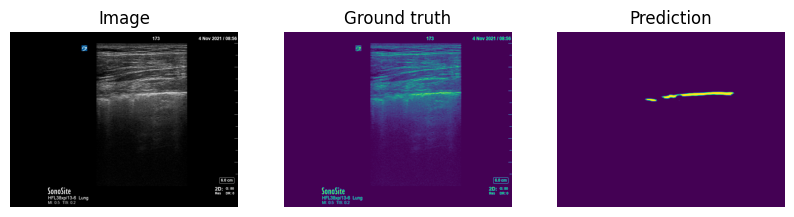

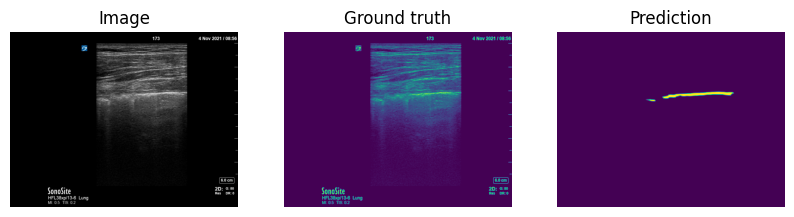

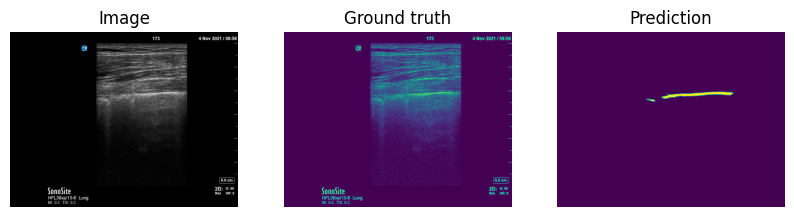

In [118]:
# batch = next(iter(inference_loader))
import matplotlib.pyplot as plt
import torch

# Assuming inference_loader is defined and model is loaded

# Set the model to evaluation mode
model_v15_new.eval() #HERE, use correct model instance
num_images_displayed = 0  # Counter for displayed images

for batch in inference_loader:
    with torch.no_grad():
        logits = model_v15_new(batch["image"]) #HERE, use correct model instance
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())  # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())  # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

        num_images_displayed += 1
        if num_images_displayed >= 10:
            break

    if num_images_displayed >= 10:
        break

Alright, perfect, that worked too. Now let's try making a video.

### Experiments in overlaying mask

In [71]:
from tqdm import tqdm

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask(image, mask, alpha=0.5):
    #make mask grayscale
    if mask.ndim == 3 and mask.shape[2] > 1:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # Apply a colormap to the mask
    colored_mask = cv2.applyColorMap((mask * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Overlay the mask on the image
    overlay = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

    return overlay

# Assuming model and inference_loader are defined and ready
model.eval()
overlaid_images = []

for batch in tqdm(inference_loader, desc="Processing images", total=180):
    with torch.no_grad():
        logits = model(batch["image"])
    pr_masks = logits.sigmoid()

    for image, pr_mask in zip(batch["image"], pr_masks):
        # Convert image and mask to numpy format
        np_image = image.numpy().transpose(1, 2, 0)
        np_image = (np_image * 255).astype(np.uint8)  # assuming image was normalized
        np_mask = pr_mask.numpy().squeeze()

        # Overlay mask on image
        overlaid_image = overlay_mask(np_image, np_mask)
        overlaid_images.append(overlaid_image)

        if len(overlaid_images) >= 180:
            break

    if len(overlaid_images) >= 180:
        break

Processing images:  99%|█████████▉| 179/180 [05:13<00:01,  1.75s/it]


In [67]:
video_name = 'overlaid_video_173-1.avi'
frame_height, frame_width = overlaid_images[0].shape[:2]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width, frame_height))

for image in tqdm(overlaid_images, desc="Processing video", total=180):
    video.write(image)

video.release()

Processing video: 100%|██████████| 180/180 [00:01<00:00, 140.77it/s]


Here's how a frame from the video looks rn:  
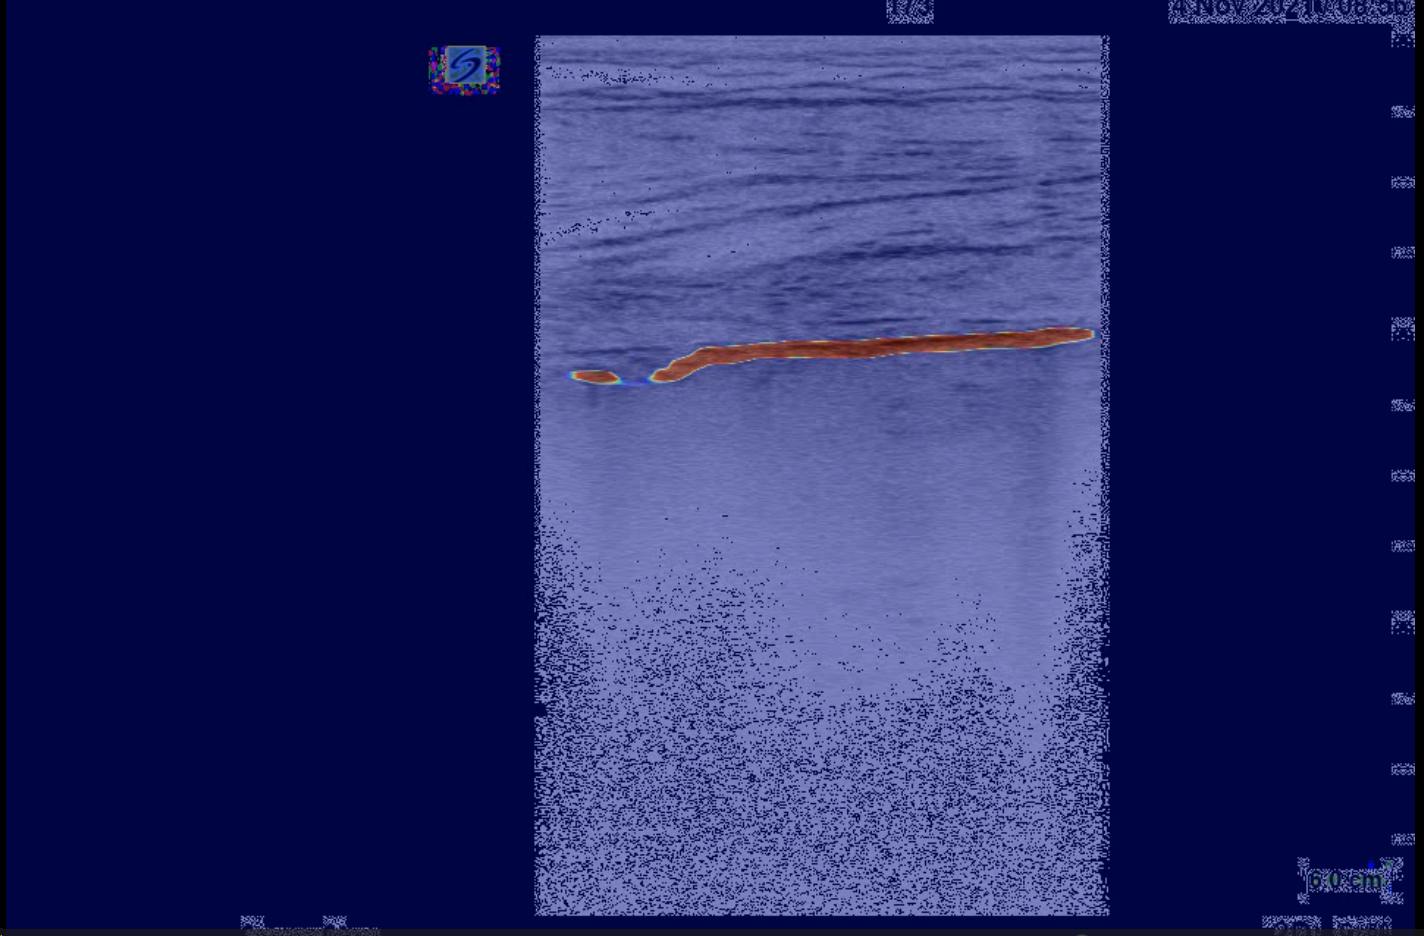

Just gotta dig a little deeper into how the mask would look added to the video, how to adjust coloring to make it sit well on top of the original video, and then execute. 

Alright. Still the damn same. Let's dig in, make the masks look good, and adjust the mask overlay code accordingly.

This is for showing images. Now apply this somehow to the image processing.

In [85]:
sample["mask"].shape

(1, 736, 960)

In [86]:
sample["image"].shape

(3, 736, 960)

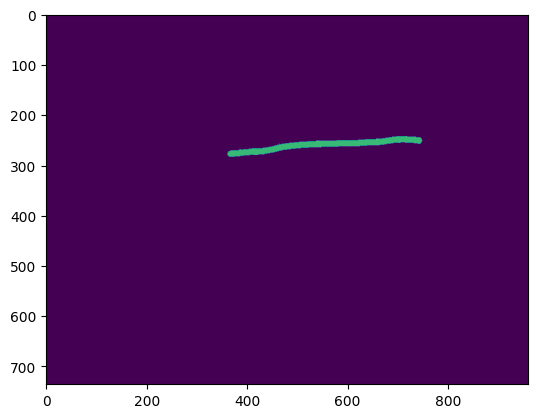

In [89]:
plt.imshow(sample["mask"].transpose(1, 2, 0))

But I do think the mask entering the dataloader is in 2D.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def overlay_mask(image, mask, alpha=0.5):
    # Ensure mask is a single channel grayscale image, add a new axis if it's a 2D array
    if mask.ndim == 2:
        mask = mask[:, :, np.newaxis]
    
    # Make sure the single channel mask is properly scaled to 0-255
    mask = (mask * 255).astype(np.uint8)

    # Apply a colormap to the mask
    colored_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)

    # Overlay the mask on the image
    overlay = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

    return overlay

# Assuming model and inference_loader are defined and ready
model.eval()
overlaid_images = []

for batch in tqdm(inference_loader, desc="Processing images", total=180):
    with torch.no_grad():
        logits = model(batch["image"])
    pr_masks = logits.sigmoid()

    for image, pr_mask in zip(batch["image"], pr_masks):
        # Convert image and mask to numpy format
        np_image = image.numpy().transpose(1, 2, 0)
        np_image = (np_image * 255).astype(np.uint8)  # assuming image was normalized
        np_mask = pr_mask.numpy().squeeze()

        # Overlay mask on image, ensuring mask is single channel
        overlaid_image = overlay_mask(np_image, np_mask)
        overlaid_images.append(overlaid_image)

        if len(overlaid_images) >= 180:
            break

    if len(overlaid_images) >= 180:
        break

Full ah one grayscale conversion

In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def overlay_mask(image, mask, alpha=0.5):
    # Ensure mask is a single channel grayscale image, even if it's already 2D
    if mask.ndim == 3 and mask.shape[2] != 1:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    elif mask.ndim == 2:
        # If mask is already 2D, no need to convert, just ensure it's the correct type
        mask = mask.astype(np.uint8)
    
    # Normalize the mask to be in the range [0, 255] if not already
    mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)

    # Convert the grayscale mask to a 3-channel image
    mask_3_channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # Overlay the 3-channel grayscale mask on the image using alpha blending
    overlay = cv2.addWeighted(image, 1-alpha, mask_3_channel, alpha, 0)

    return overlay

# Assuming model and inference_loader are defined and ready
model.eval()
overlaid_images = []
alpha = 0.5  # Define alpha here

for batch in tqdm(inference_loader, desc="Processing images", total=180):
    with torch.no_grad():
        logits = model(batch["image"])
    pr_masks = logits.sigmoid()

    for image, pr_mask in zip(batch["image"], pr_masks):
        # Convert image to numpy format
        np_image = image.numpy().transpose(1, 2, 0)
        np_image = (np_image * 255).astype(np.uint8)  # assuming image was normalized
        
        # Convert mask to numpy format and ensure it's a single channel grayscale image
        np_mask = pr_mask.numpy().squeeze()
        np_mask = (np_mask * 255).astype(np.uint8)  # Scale the mask to [0, 255]
        
        # Overlay grayscale mask on image
        overlaid_image = overlay_mask(np_image, np_mask, alpha=alpha)
        overlaid_images.append(overlaid_image)

        if len(overlaid_images) >= 180:
            break

    if len(overlaid_images) >= 180:
        break



Processing images:  17%|█▋        | 30/180 [00:48<04:01,  1.61s/it]


KeyboardInterrupt: 

In [94]:
video_name = 'overlaid_video_173-1_grayscale.avi'
frame_height, frame_width = overlaid_images[0].shape[:2]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width, frame_height))

for image in tqdm(overlaid_images, desc="Processing video", total=180):
    video.write(image)

video.release()


Processing video: 100%|██████████| 180/180 [00:01<00:00, 148.18it/s]


This is how the video looks now:  
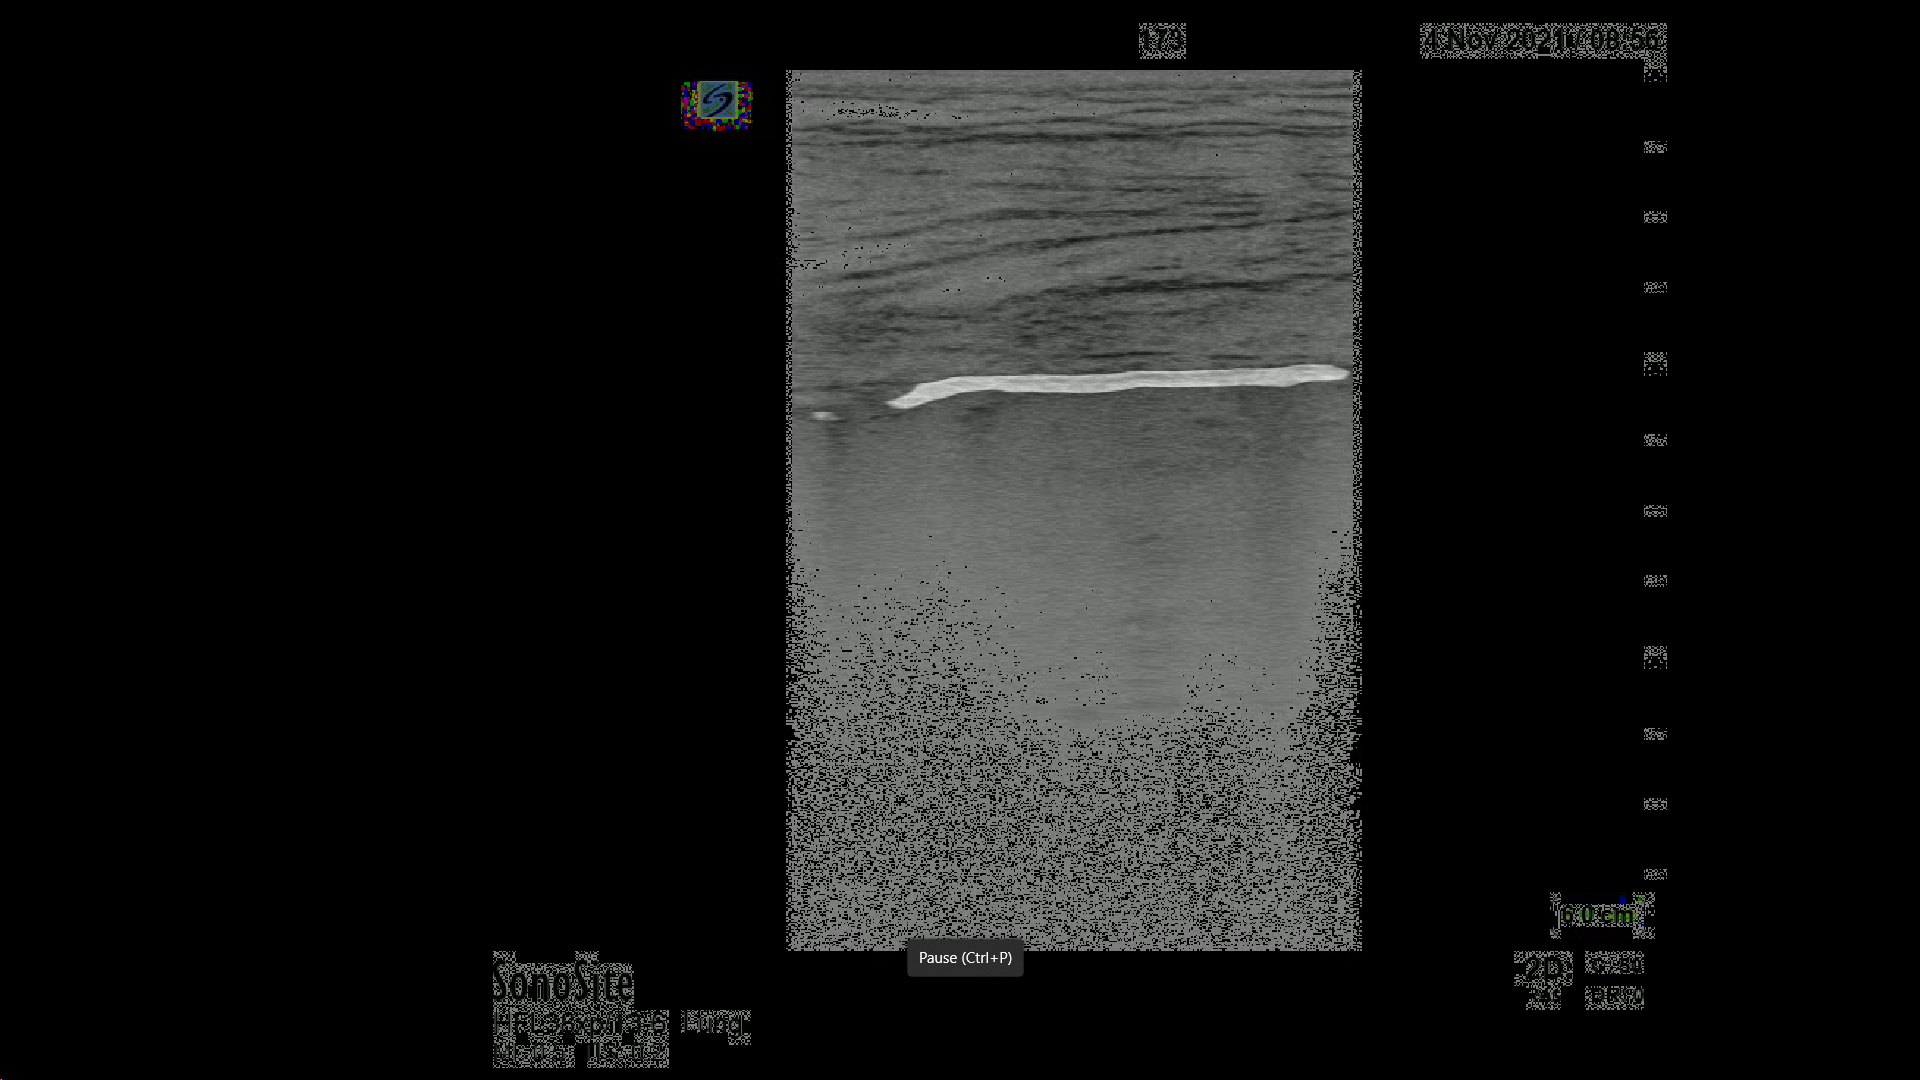

It's working, but why is messing with the original image??

### Checks 

Asked GPT to help me visualize every step of the processing. I think I'm messing up somewhere - the image has to be called, and just added to the mask. Where are we messing up?

In [78]:
def overlay_mask(image, mask, alpha=0.5):
    #make mask grayscale
    # if mask.ndim == 3 and mask.shape[2] > 1:
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # Apply a colormap to the mask
    # colored_mask = cv2.applyColorMap((mask * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Overlay the mask on the image
    # overlay = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)
    overlay = cv2.addWeighted(image, 1-alpha, mask, alpha, 0)

    return overlay

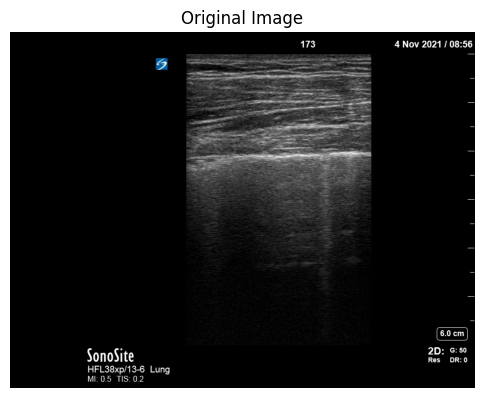

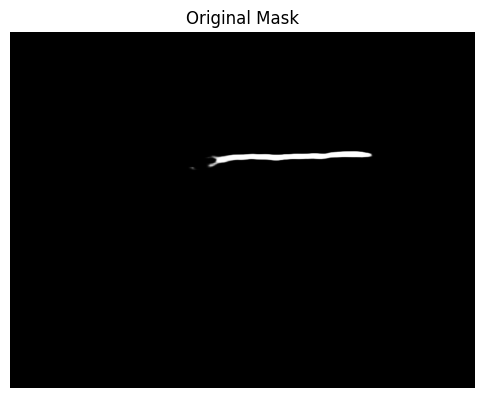

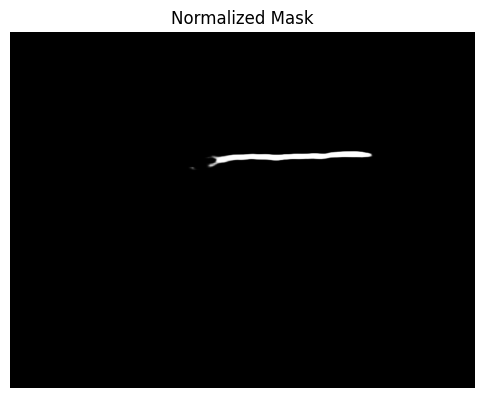

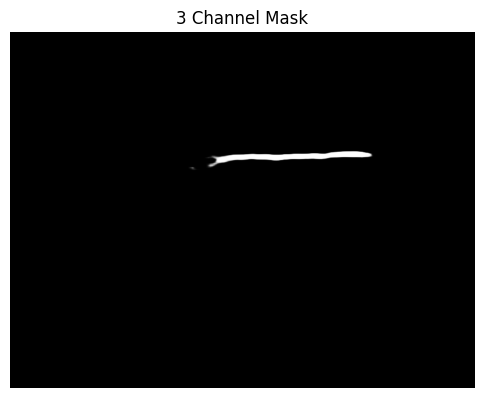

Image shape: (736, 960, 3)
Mask shape: (736, 960, 3)


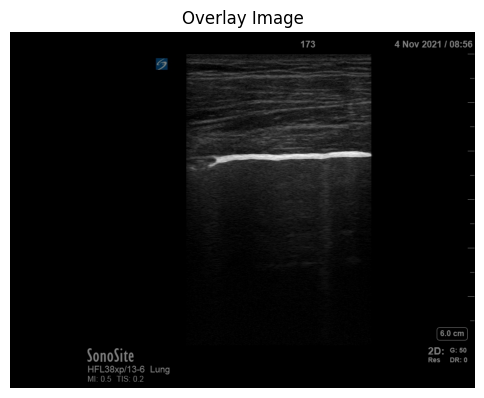

In [79]:
import matplotlib.pyplot as plt

def visualize_image(title, image, cmap=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Process just one batch for visualization
batch = next(iter(inference_loader))
with torch.no_grad():
    logits = model_v15_new(batch["image"])
pr_masks = logits.sigmoid()

# Select the first image and mask for demonstration
np_image = batch["image"][0].numpy().transpose(1, 2, 0)
# np_image = (np_image * 255).astype(np.uint8)
np_mask = pr_masks[0].numpy().squeeze()
np_mask = (np_mask * 255).astype(np.uint8)

# Visualize original image and mask
visualize_image("Original Image", np_image)
visualize_image("Original Mask", np_mask, cmap='gray')

# Check if mask needs to be converted to grayscale and visualize
if np_mask.ndim == 3 and np_mask.shape[2] != 1:
    np_mask = cv2.cvtColor(np_mask, cv2.COLOR_BGR2GRAY)
    visualize_image("Converted to Grayscale Mask", np_mask, cmap='gray')

# Normalize mask and visualize
np_mask = cv2.normalize(np_mask, None, 0, 255, cv2.NORM_MINMAX)
visualize_image("Normalized Mask", np_mask, cmap='gray')

# Convert mask to 3 channels and visualize
mask_3_channel = cv2.cvtColor(np_mask, cv2.COLOR_GRAY2BGR)
visualize_image("3 Channel Mask", mask_3_channel)
print("Image shape:", np_image.shape)
print("Mask shape:", mask_3_channel.shape)

# Overlay mask on image and visualize
overlaid_image = overlay_mask(np_image, mask_3_channel, alpha=0.5)
visualize_image("Overlay Image", overlaid_image)


Alright, looks good - but that took a while to process. Maybe I can figure out a way to overlay a single-channel mask instead of a 3-channel mask, but will get to that later. Now JUST try adding a color map to the mask and adding it to the image:

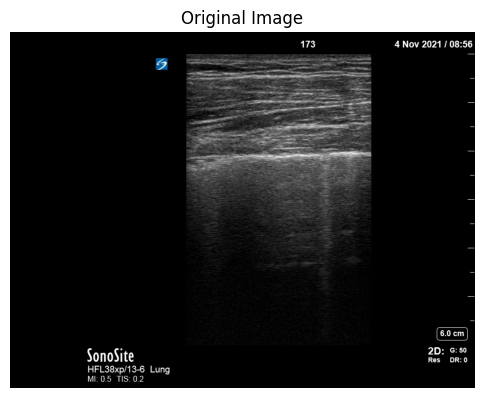

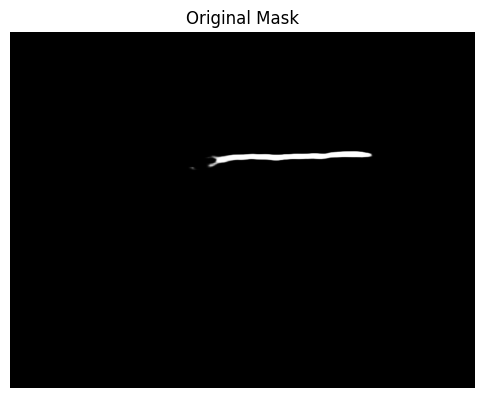

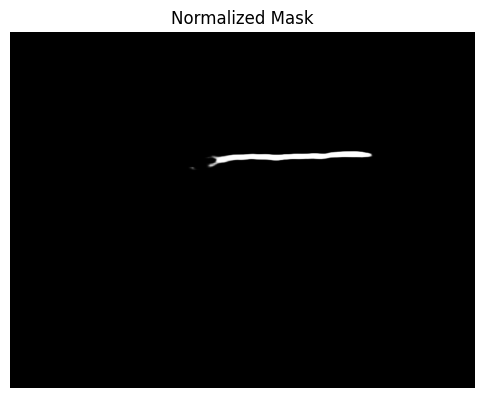

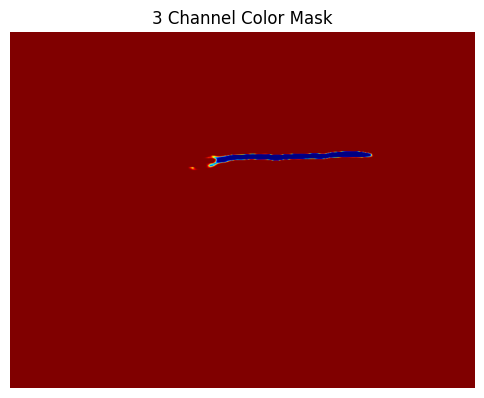

Image shape: (736, 960, 3)
Mask shape: (736, 960, 3)


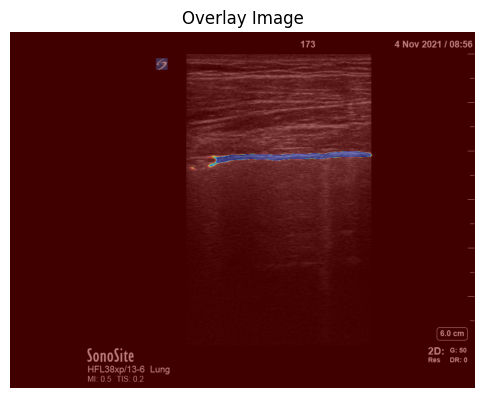

In [81]:
import matplotlib.pyplot as plt

def visualize_image(title, image, cmap=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Process just one batch for visualization
batch = next(iter(inference_loader))
with torch.no_grad():
    logits = model_v15_new(batch["image"])
pr_masks = logits.sigmoid()

# Select the first image and mask for demonstration
np_image = batch["image"][0].numpy().transpose(1, 2, 0)
# np_image = (np_image * 255).astype(np.uint8)
np_mask = pr_masks[0].numpy().squeeze()
np_mask = (np_mask * 255).astype(np.uint8)

# Visualize original image and mask
visualize_image("Original Image", np_image)
visualize_image("Original Mask", np_mask, cmap='gray')

# Check if mask needs to be converted to grayscale and visualize
if np_mask.ndim == 3 and np_mask.shape[2] != 1:
    np_mask = cv2.cvtColor(np_mask, cv2.COLOR_BGR2GRAY)
    visualize_image("Converted to Grayscale Mask", np_mask, cmap='gray')

# Normalize mask and visualize
np_mask = cv2.normalize(np_mask, None, 0, 255, cv2.NORM_MINMAX)
visualize_image("Normalized Mask", np_mask, cmap='gray')

# Convert mask to 3 channels and visualize
mask_3_channel = cv2.cvtColor(np_mask, cv2.COLOR_GRAY2BGR)
#add color
colored_mask = cv2.applyColorMap(mask_3_channel, cv2.COLORMAP_JET)
visualize_image("3 Channel Color Mask", colored_mask)
print("Image shape:", np_image.shape)
print("Mask shape:", mask_3_channel.shape)

# Overlay mask on image and visualize
overlaid_image = overlay_mask(np_image, colored_mask, alpha=0.5)
visualize_image("Overlay Image", overlaid_image)


Just need to understand how the values look like, and work with them a bit to get the colormap to do what we want it to:

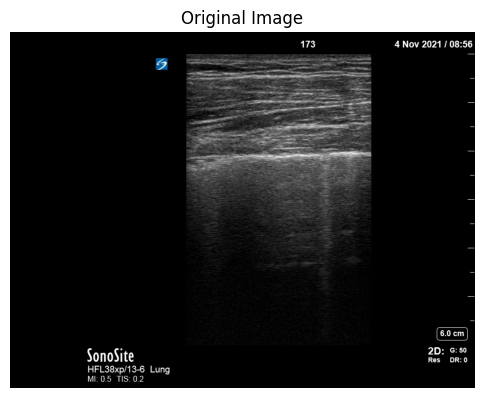

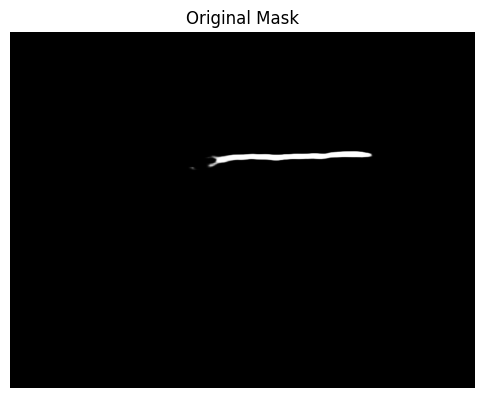

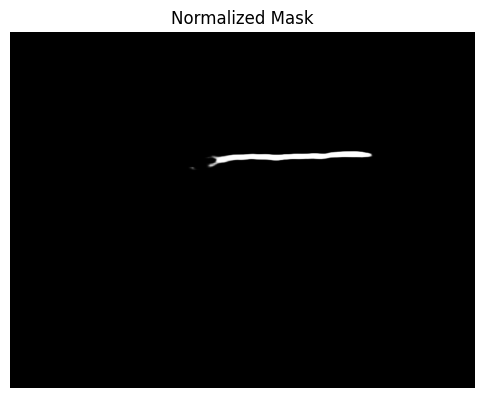

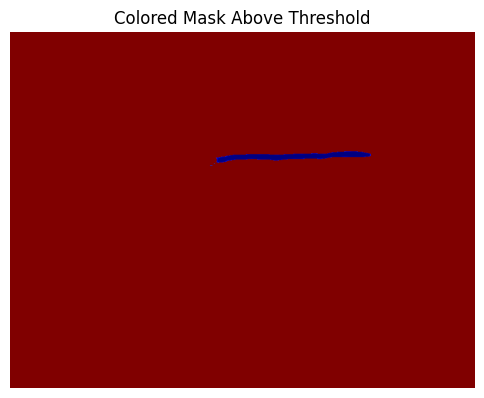

In [84]:
import matplotlib.pyplot as plt

def visualize_image(title, image, cmap=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Process just one batch for visualization
batch = next(iter(inference_loader))
with torch.no_grad():
    logits = model_v15_new(batch["image"])
pr_masks = logits.sigmoid()

# Select the first image and mask for demonstration
np_image = batch["image"][0].numpy().transpose(1, 2, 0)
# np_image = (np_image * 255).astype(np.uint8)
np_mask = pr_masks[0].numpy().squeeze()
np_mask = (np_mask * 255).astype(np.uint8)

# Visualize original image and mask
visualize_image("Original Image", np_image)
visualize_image("Original Mask", np_mask, cmap='gray')

# Check if mask needs to be converted to grayscale and visualize
if np_mask.ndim == 3 and np_mask.shape[2] != 1:
    np_mask = cv2.cvtColor(np_mask, cv2.COLOR_BGR2GRAY)
    visualize_image("Converted to Grayscale Mask", np_mask, cmap='gray')

# Normalize mask and visualize
np_mask = cv2.normalize(np_mask, None, 0, 255, cv2.NORM_MINMAX)
visualize_image("Normalized Mask", np_mask, cmap='gray')

# Assuming a threshold value (e.g., 0.5 in your normalized mask)
threshold_value = 0.8 * 255  # Assuming mask is scaled to [0, 255]
mask_above_threshold = np_mask.copy()

# Apply threshold
mask_above_threshold[np_mask < threshold_value] = 0

# Convert thresholded mask to 3 channels
mask_above_threshold_3_channel = cv2.cvtColor(mask_above_threshold, cv2.COLOR_GRAY2BGR)

# Apply colormap
colored_mask = cv2.applyColorMap(mask_above_threshold_3_channel, cv2.COLORMAP_JET)

# Visualize colored mask
visualize_image("Colored Mask Above Threshold", colored_mask)

The first color in a usual colormap apparently corresponds to zero. So modify that

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def create_custom_colormap():
    # Get the JET colormap from OpenCV
    colormap = cv2.applyColorMap(np.arange(256, dtype=np.uint8), cv2.COLORMAP_JET)
    # any color that indicates 'no change'
    colormap[0] = [0, 0, 0]  # Setting the first color to black
    return colormap

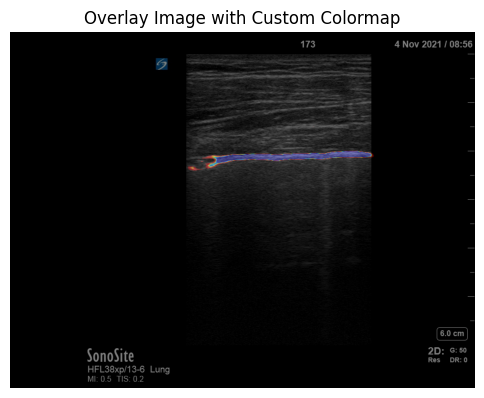

In [88]:
# Create the custom colormap
cust_colormap = create_custom_colormap()

# Convert mask to 3 channels
mask_3_channel = cv2.cvtColor(np_mask, cv2.COLOR_GRAY2BGR)

# Apply the custom colormap
# Note: You need to use LUT (Look-Up Table) for custom colormaps
colored_mask = cv2.LUT(mask_3_channel, cust_colormap)

# Overlay mask on image and visualize
overlaid_image = overlay_mask(np_image, colored_mask, alpha=0.5)
visualize_image("Overlay Image with Custom Colormap", overlaid_image)

Hell yes, that worked. The pleural line displays in blue. I think it might display in red if I plug this into my code below, let's see.

### Final:

In [119]:
def create_custom_colormap():
    # Get the JET colormap from OpenCV
    colormap = cv2.applyColorMap(np.arange(256, dtype=np.uint8), cv2.COLORMAP_JET)
    # any color that indicates 'no change'
    colormap[0] = [0, 0, 0]  # Setting the first color to black
    return colormap

In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def overlay_mask(image, mask, alpha=0.5):
    # Ensure mask is a single channel grayscale image, even if it's already 2D
    if mask.ndim == 3 and mask.shape[2] != 1:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    elif mask.ndim == 2:
        # If mask is already 2D, no need to convert, just ensure it's the correct type
        mask = mask.astype(np.uint8)
    
    # Normalize the mask to be in the range [0, 255] if not already
    mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)

    cust_colormap = create_custom_colormap()
    # Convert the grayscale mask to a 3-channel image
    mask= cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    colored_mask = cv2.LUT(mask, cust_colormap)
    
    # Overlay the 3-channel grayscale mask on the image using alpha blending
    overlay = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

    return overlay

# Assuming model and inference_loader are defined and ready
model_v15_new.eval()
overlaid_images = []
alpha = 0.5  # Define alpha here

for batch in tqdm(inference_loader, desc="Processing images", total=180):
    with torch.no_grad():
        logits = model_v15_new(batch["image"])
    pr_masks = logits.sigmoid()

    for image, pr_mask in zip(batch["image"], pr_masks):
        # Convert image to numpy format
        np_image = image.numpy().transpose(1, 2, 0)
        # np_image = (np_image * 255).astype(np.uint8)  # assuming image was normalized
        
        # Convert mask to numpy format and ensure it's a single channel grayscale image
        np_mask = pr_mask.numpy().squeeze()
        np_mask = (np_mask * 255).astype(np.uint8)  # Scale the mask to [0, 255]
        
        # Overlay mask on image
        overlaid_image = overlay_mask(np_image, np_mask, alpha=alpha)
        overlaid_images.append(overlaid_image)

        if len(overlaid_images) >= 180:
            break

    if len(overlaid_images) >= 180:
        break


Processing images:  99%|█████████▉| 179/180 [03:13<00:01,  1.08s/it]


In [121]:
video_name = 'overlaid_video_173-1_FINAL10fps.avi'
frame_height, frame_width = overlaid_images[0].shape[:2]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width, frame_height))

for image in tqdm(overlaid_images, desc="Processing video", total=180):
    video.write(image)

video.release()

Processing video: 100%|██████████| 180/180 [00:00<00:00, 304.42it/s]


In [122]:
video_name = 'overlaid_video_173-1_FINAL30fps.avi'
frame_height, frame_width = overlaid_images[0].shape[:2]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for image in tqdm(overlaid_images, desc="Processing video", total=180):
    video.write(image)

video.release()

Processing video: 100%|██████████| 180/180 [00:00<00:00, 304.69it/s]


### Inference (on broken Pleura)

Once the mask overlay and video creation is sorted, should try running inference on a video with broken pleura, to see how the model performs (I don't think the training examples had any broken pleura, but I think I should just try running inference and see what happens).

Which video am I picking?  
(possible picks - 177-4,  167-1, 202-2)  
Would be interesting to try on 167-1 (pleura unbroken, but then the pleura slides - so can look at what the model can do.)

Issues that i'm curious to see if this model can handle:  
202-2 - The pleural line slides and breaks a little.  
202-3 - Pleura is not as clear, and there is also a bright fascia band above which the model might mistake for pleura  
202-5 - Lots of Blines, which could be mistaken for pleura.

In [99]:
import os
import re

In [100]:
#updated Dataset with mask processing
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        def extract_frame_number(filename):
            # Extract the frame number using a regular expression
            match = re.search(r'frame_(\d+)', filename)
            return int(match.group(1)) if match else 0
        # self.ids = os.listdir(images_dir)
        self.ids = [file for file in os.listdir(images_dir) if file.endswith(('.jpg', '.png', '.jpeg')) and not file.startswith('.')]
        # Sort the file list based on the frame number
        self.ids.sort(key=extract_frame_number)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg', '.png')) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        if image is None:
            raise FileNotFoundError(f"Unable to load image at {self.images_fps[i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1))
        image = pad_im(image)
        
        # image = convert_im(image)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = convert_mask(mask)
        mask = pad_im(mask)
            
        return {"image": image, "mask": mask}

    def __len__(self):
        return len(self.ids)

In [101]:
x_inf_dir2 = '/notebooks/pleural_line_segment/init_play/baby_dataset/inf/202-3/image'
y_inf_dir2 = '/notebooks/pleural_line_segment/init_play/baby_dataset/inf/202-3/mask'

In [102]:
# inf_dataset = InfDataset(
inf_dataset2 = Dataset(
    x_inf_dir2, 
    y_inf_dir2
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

In [103]:
inference_loader2 = DataLoader(inf_dataset2, batch_size=1, shuffle=False, num_workers=4)

Let's try running inference:

In [104]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=3,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [105]:
# run test dataset
inf_metrics = trainer.test(model_v15_new, dataloaders=inference_loader2, verbose=False)
pprint(inf_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.0, 'test_per_image_iou': 0.0}]


Okay so, I can use my own simplifed code to run inference (and load checkpoint). But for now lemme try with the code that's here (no mask? just add the og images in mask folder).

In [ ]:
# # batch = next(iter(inference_loader))
# with torch.no_grad():
#     model.eval()
#     logits = model(batch["image"])
# pr_masks = logits.sigmoid()

# for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
#     plt.title("Image")
#     plt.axis("off")

#     plt.subplot(1, 3, 2)
#     plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
#     plt.title("Ground truth")
#     plt.axis("off")

#     plt.subplot(1, 3, 3)
#     plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
#     plt.title("Prediction")
#     plt.axis("off")

# model.eval()
#         logits = model(batch["image"])
#     plt.show()

Run inference on the 180 frames of video `202-3.avi`:  
(Note - Here, be careful to use the correct model instance! For example, use `model_v15_new` at every appropriate point, not `model`.)

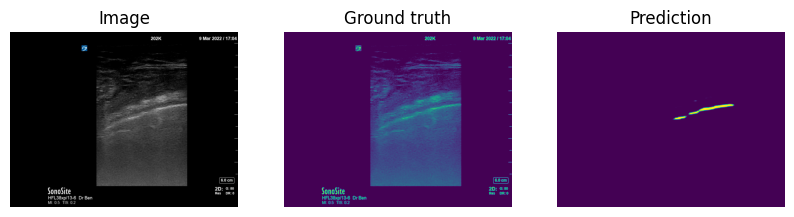

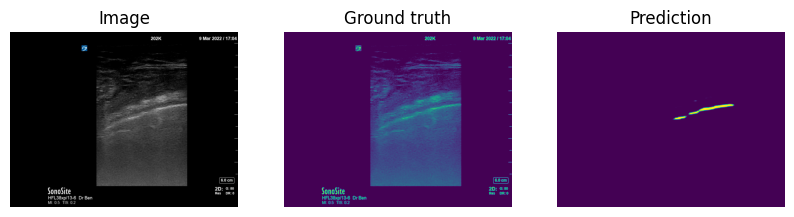

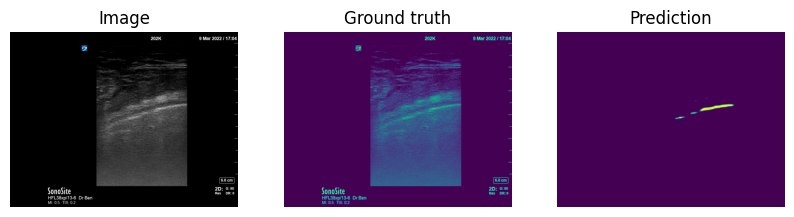

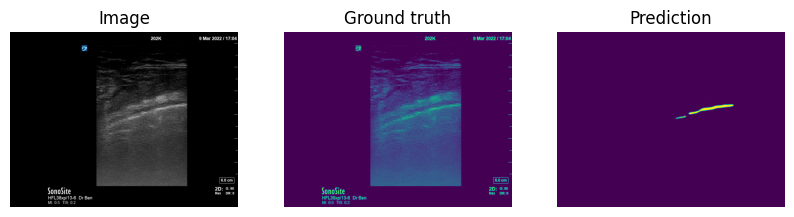

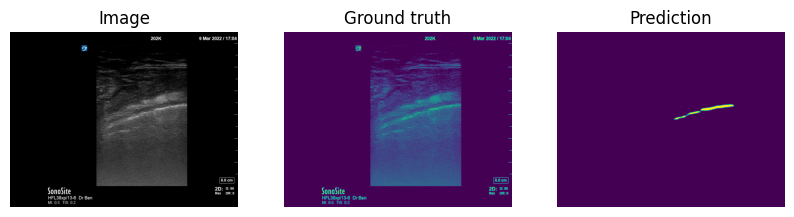

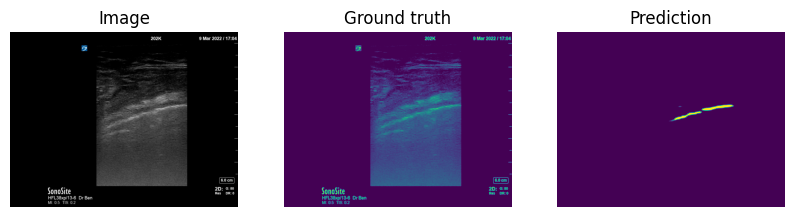

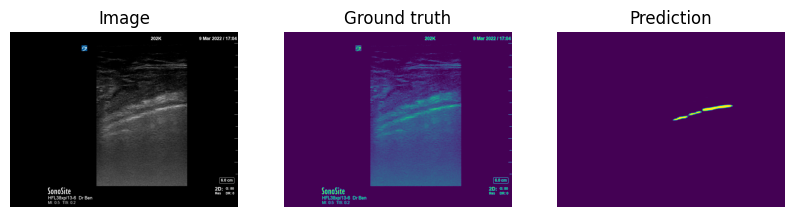

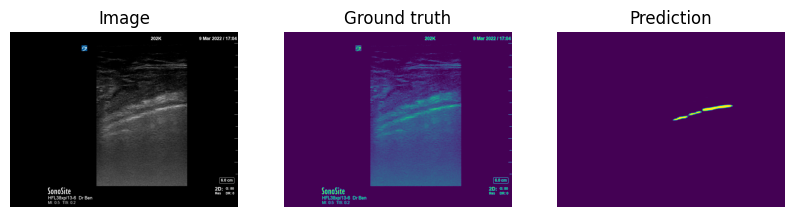

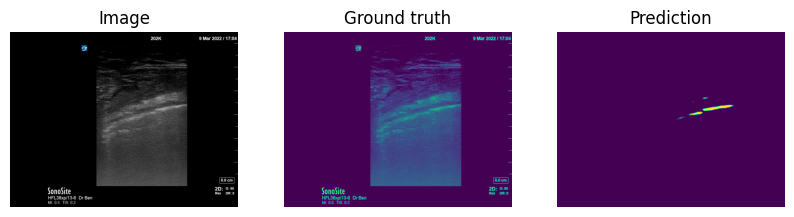

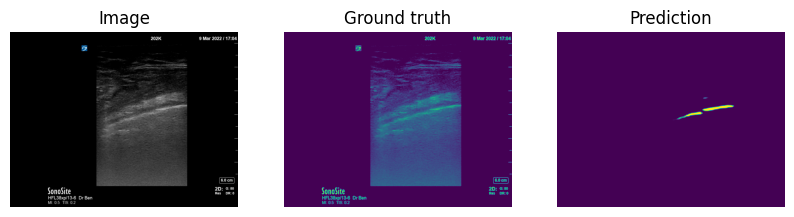

In [107]:
# batch = next(iter(inference_loader))
import matplotlib.pyplot as plt
import torch

# Assuming inference_loader is defined and model is loaded

# Set the model to evaluation mode
model_v15_new.eval() #HERE, use correct model instance
num_images_displayed = 0  # Counter for displayed images

for batch in inference_loader2:
    with torch.no_grad():
        logits = model_v15_new(batch["image"]) #HERE, use correct model instance
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())  # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())  # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

        num_images_displayed += 1
        if num_images_displayed >= 10:
            break

    if num_images_displayed >= 10:
        break

The model is 'less sure' about marking the pleural lines here, see? If I use the v16 checkpoint I'm sure it'll do better.

In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def overlay_mask(image, mask, alpha=0.5):
    # Ensure mask is a single channel grayscale image, even if it's already 2D
    if mask.ndim == 3 and mask.shape[2] != 1:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    elif mask.ndim == 2:
        # If mask is already 2D, no need to convert, just ensure it's the correct type
        mask = mask.astype(np.uint8)
    
    # Normalize the mask to be in the range [0, 255] if not already
    mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)

    cust_colormap = create_custom_colormap()
    # Convert the grayscale mask to a 3-channel image
    mask= cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    colored_mask = cv2.LUT(mask, cust_colormap)
    
    # Overlay the 3-channel grayscale mask on the image using alpha blending
    overlay = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

    return overlay

# Assuming model and inference_loader are defined and ready
model_v15_new.eval()
overlaid_images = []
alpha = 0.5  # Define alpha here

for batch in tqdm(inference_loader2, desc="Processing images", total=180):
    with torch.no_grad():
        logits = model_v15_new(batch["image"])
    pr_masks = logits.sigmoid()

    for image, pr_mask in zip(batch["image"], pr_masks):
        # Convert image to numpy format
        np_image = image.numpy().transpose(1, 2, 0)
        # np_image = (np_image * 255).astype(np.uint8)  # assuming image was normalized
        
        # Convert mask to numpy format and ensure it's a single channel grayscale image
        np_mask = pr_mask.numpy().squeeze()
        np_mask = (np_mask * 255).astype(np.uint8)  # Scale the mask to [0, 255]
        
        # Overlay mask on image
        overlaid_image = overlay_mask(np_image, np_mask, alpha=alpha)
        overlaid_images.append(overlaid_image)

        if len(overlaid_images) >= 180:
            break

    if len(overlaid_images) >= 180:
        break


Processing images:  99%|█████████▉| 179/180 [01:40<00:00,  1.79it/s]


In [110]:
video_name = 'overlaid_video_202-3_final10fps.avi'
frame_height, frame_width = overlaid_images[0].shape[:2]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width, frame_height))

for image in tqdm(overlaid_images, desc="Processing video", total=180):
    video.write(image)

video.release()

Processing video: 100%|██████████| 180/180 [00:00<00:00, 312.44it/s]


In [111]:
video_name = 'overlaid_video_202-3_final30fps.avi'
frame_height, frame_width = overlaid_images[0].shape[:2]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for image in tqdm(overlaid_images, desc="Processing video", total=180):
    video.write(image)

video.release()

Processing video: 100%|██████████| 180/180 [00:00<00:00, 315.22it/s]


### Inference (on difficult Pleura)

Remember the video from training 2? What can this model do with that video? Which video is it?

In [123]:
x_inf_dir3 = '/notebooks/pleural_line_segment/init_play/baby_dataset/inf/155-1/image'
y_inf_dir3 = '/notebooks/pleural_line_segment/init_play/baby_dataset/inf/155-1/mask'

In [125]:
# inf_dataset = InfDataset(
inf_dataset3 = Dataset(
    x_inf_dir3, 
    y_inf_dir3
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

In [126]:
inference_loader3 = DataLoader(inf_dataset3, batch_size=1, shuffle=False, num_workers=4)

Let's try running inference:

In [127]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=3,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [128]:
# run test dataset
inf_metrics = trainer.test(model_v15_new, dataloaders=inference_loader3, verbose=False)
pprint(inf_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.0, 'test_per_image_iou': 0.0}]


Okay so, I can use my own simplifed code to run inference (and load checkpoint). But for now lemme try with the code that's here (no mask? just add the og images in mask folder).

Run inference on the 180 frames of video `155-1.avi`:  
(Note - Here, be careful to use the correct model instance! For example, use `model_v15_new` at every appropriate point, not `model`.)

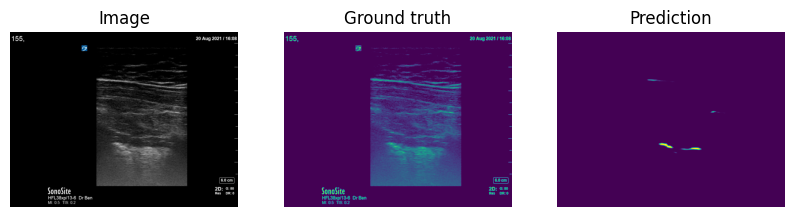

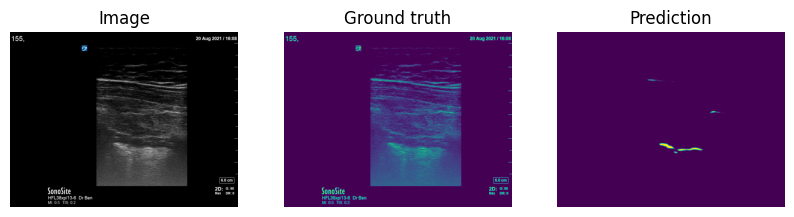

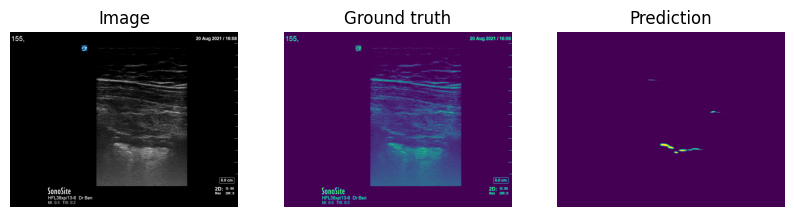

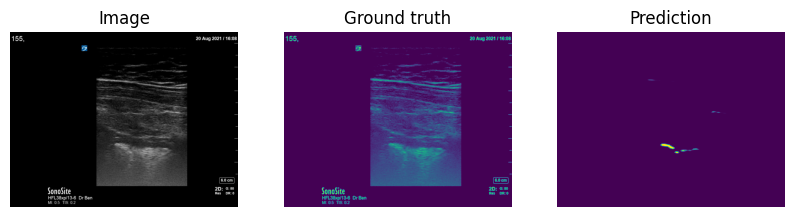

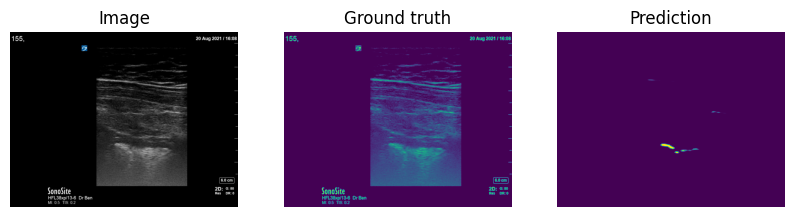

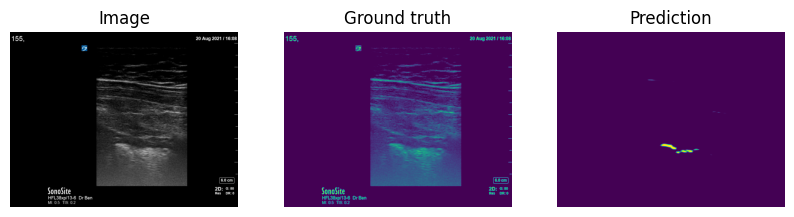

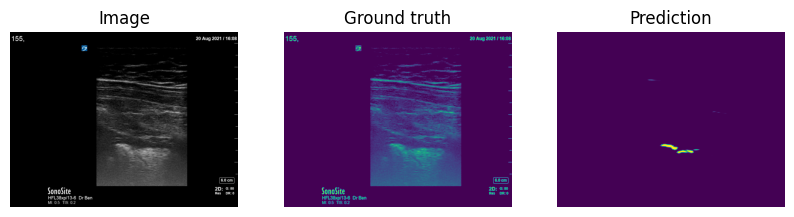

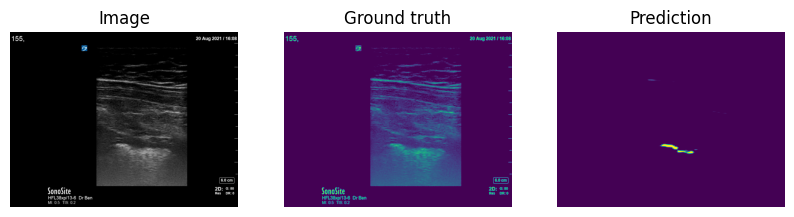

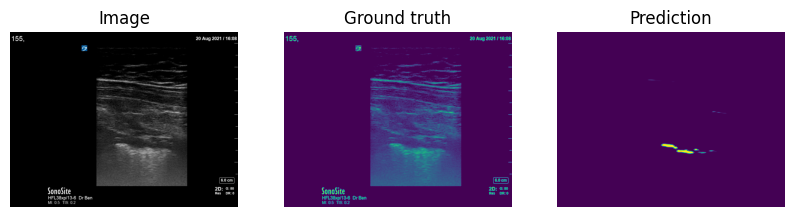

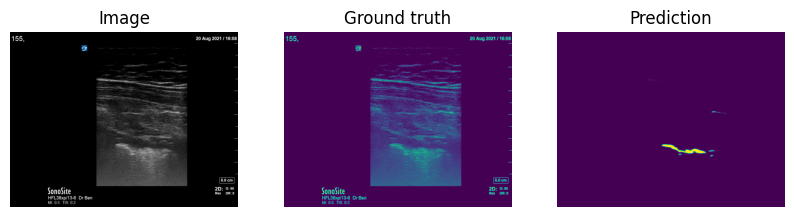

In [129]:
# batch = next(iter(inference_loader))
import matplotlib.pyplot as plt
import torch

# Assuming inference_loader is defined and model is loaded

# Set the model to evaluation mode
model_v15_new.eval() #HERE, use correct model instance
num_images_displayed = 0  # Counter for displayed images

for batch in inference_loader3:
    with torch.no_grad():
        logits = model_v15_new(batch["image"]) #HERE, use correct model instance
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())  # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())  # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

        num_images_displayed += 1
        if num_images_displayed >= 10:
            break

    if num_images_displayed >= 10:
        break

The model is 'less sure' about marking the pleural lines here, see? If I use the v16 checkpoint I'm sure it'll do better. Try that.

In [133]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def overlay_mask(image, mask, alpha=0.5):
    # Ensure mask is a single channel grayscale image, even if it's already 2D
    if mask.ndim == 3 and mask.shape[2] != 1:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    elif mask.ndim == 2:
        # If mask is already 2D, no need to convert, just ensure it's the correct type
        mask = mask.astype(np.uint8)
    
    # Normalize the mask to be in the range [0, 255] if not already
    mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)

    cust_colormap = create_custom_colormap()
    # Convert the grayscale mask to a 3-channel image
    mask= cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    colored_mask = cv2.LUT(mask, cust_colormap)
    
    # Overlay the 3-channel grayscale mask on the image using alpha blending
    overlay = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)

    return overlay

# Assuming model and inference_loader are defined and ready
model_v15_new.eval()
overlaid_images = []
alpha = 0.5  # Define alpha here

for batch in tqdm(inference_loader3, desc="Processing images", total=180):
    with torch.no_grad():
        logits = model_v15_new(batch["image"])
    pr_masks = logits.sigmoid()

    for image, pr_mask in zip(batch["image"], pr_masks):
        # Convert image to numpy format
        np_image = image.numpy().transpose(1, 2, 0)
        # np_image = (np_image * 255).astype(np.uint8)  # assuming image was normalized
        
        # Convert mask to numpy format and ensure it's a single channel grayscale image
        np_mask = pr_mask.numpy().squeeze()
        np_mask = (np_mask * 255).astype(np.uint8)  # Scale the mask to [0, 255]
        
        # Overlay mask on image
        overlaid_image = overlay_mask(np_image, np_mask, alpha=alpha)
        overlaid_images.append(overlaid_image)

        if len(overlaid_images) >= 180:
            break

    if len(overlaid_images) >= 180:
        break


Processing images:  99%|█████████▉| 179/180 [02:12<00:00,  1.35it/s]


In [134]:
video_name = 'overlaid_video_155-1_final10fps.avi'
frame_height, frame_width = overlaid_images[0].shape[:2]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width, frame_height))

for image in tqdm(overlaid_images, desc="Processing video", total=180):
    video.write(image)

video.release()

Processing video: 100%|██████████| 180/180 [00:00<00:00, 299.00it/s]


In [135]:
video_name = 'overlaid_video_155-1_final30fps.avi'
frame_height, frame_width = overlaid_images[0].shape[:2]
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for image in tqdm(overlaid_images, desc="Processing video", total=180):
    video.write(image)

video.release()

Processing video: 100%|██████████| 180/180 [00:00<00:00, 301.41it/s]


### Inference (Chkpoint 16)

Just to show how the model is behaving differently in a different run (with no change in params). This is so we can show the doctors that we have these 2 models, and hey, we just need properly annotated data!